# Transformer 从零开始实现
论文：[Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

## 网络结构
<img src="./img/Transformer-1.png" width = "200" height = "300" alt="Transformer 网络结构" align=center />
<p>
Transformer的基本结构是 encoder-decoder 结构:<br>
encoder: 输入序列的表示 (x1,...,xn) -->连续序列的表示 z=(z1,...,zn)。<br>
decoder: z --> 输出序列 (y1,...,ym), 一次输出一个元素。<br>
上面每一步的模型都是自回归的(AR),每次输出一个元素都将该元素添加到下一轮的输入中。
</p>

## Attention
<img src="./img/Transformer-2.png" width = "400" height = "200" alt="Attention 结构" align=center />

attention可以被描述为: query x1 + (key, value) xN --> output x1

### Scaled Dot-Product Attention
$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt d_k})V
\\
Q\in R^{b\times s_q\times d_q}
\\
K\in R^{b\times s_k\times d_k}
\\
V\in R^{b\times s_v\times d_v}
\\
d_q=d_k
\\
沿着每行应用softmax转换为概率分布
$$

### Multi-Head Attention
$$
MultiHead(Q,K,V)=Concat(head_1,...,head_h)W^O
\\
head_i=Attention(Q{W_i}^Q,K{W_i}^K,V{W_i}^V)
\\
h=8,d_k=d_v=d_{model}/h=64
\\
{W_i}^Q \in R^{d_{model}\times d_k}
\\
{W_i}^K \in R^{d_{model}\times d_k}
\\
{W_i}^V \in R^{d_{model}\times d_v}
\\
{W}^O \in R^{hd_{model}\times d_v}
$$

In [9]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

In [4]:
def sequence_mask(X, valid_len, value=0):
    '''在序列中掩蔽不相关的项
    args:
        X:          tensor (batch_size * seq_len, d_model)
        valid_len:  tensor (batch_size * seq_len,)
    return:
        tensor (batch_size * seq_len, d_model)
    '''
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

sequence_mask(torch.tensor([[1,2,3],[4,5,6]]), torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [6]:
def masked_softmax(X, valid_lens):
    '''通过在最后一个轴上掩蔽元素来执行softmax操作
    args:
        X:          tensor (batch_size, seq_len, d_model)
        valid_lens: tensor (batch_size,) or (batch_size, seq_len)
    return:
        tensor (batch_size, seq_len, d_model)
    '''
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # d_model轴上被掩蔽的元素使用一个非常大的负值替换，从而使其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

masked_softmax(torch.rand(2,3,4), torch.tensor([2,3]))

tensor([[[0.2778, 0.7222, 0.0000, 0.0000],
         [0.5218, 0.4782, 0.0000, 0.0000],
         [0.6787, 0.3213, 0.0000, 0.0000]],

        [[0.2580, 0.4156, 0.3264, 0.0000],
         [0.2385, 0.3897, 0.3718, 0.0000],
         [0.3803, 0.2465, 0.3731, 0.0000]]])

In [ ]:
class DotProductAttention(nn.Module):
    '''缩放点积注意力'''
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        '''
        args:
            queries:    tensor (batch_size, seq_len_q, d_model)
            keys:       tensor (batch_size, seq_len, d_model)
            values:     tensor (batch_size, seq_len, d_v)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            tensor (batch_size, seq_len_q, d_v)
        '''
        d = queries.shape[-1]
        
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
    
queries     = torch.normal(0, 1, (2,3,10))
keys        = torch.normal(0, 1, (2,5,10))
values      = torch.normal(0, 1, (2,5,15))
valid_lens  = torch.tensor([3,8])
attetion    = DotProductAttention(dropout=0.5)
attetion.eval()
attetion(queries, keys, values, valid_lens).shape, attetion.attention_weights.shape

(torch.Size([2, 3, 15]), torch.Size([2, 3, 5]))

/tmp/ipykernel_1288944/772604025.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


tensor([[[0.4881, 0.1002, 0.4116, 0.0000, 0.0000],
         [0.1103, 0.4766, 0.4131, 0.0000, 0.0000],
         [0.3673, 0.2478, 0.3849, 0.0000, 0.0000]],

        [[0.0588, 0.0963, 0.1631, 0.5988, 0.0830],
         [0.1698, 0.2655, 0.1036, 0.0270, 0.4341],
         [0.5226, 0.2241, 0.0886, 0.1000, 0.0647]]])

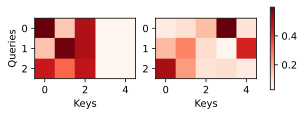

In [24]:
def use_svg_display():
    '''在jupyter中使用svg格式显示plot'''
    display.set_matplotlib_formats('svg')

def show_heatmaps(metrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5), cmap='Reds'):
    '''显示矩阵热图
    args:
        metrices: tensor (plot_num, subplot_num or batch_size, seq_len_q, seq_len_k)
    '''
    use_svg_display()
    num_rows, num_cols = metrices.shape[0], metrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0]*num_cols, figsize[1]*num_rows),
                             sharex=False, sharey=False, squeeze=False)
    for i, (row_axes, row_metrices) in enumerate(zip(axes, metrices)):
        for j, (ax, matirx) in enumerate(zip(row_axes, row_metrices)):
            pcm = ax.imshow(matirx.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


show_heatmaps(attetion.attention_weights.reshape((1,2,3,5)), xlabel='Keys', ylabel='Queries')
attetion.attention_weights

In [ ]:
class MultiHeadAttention(nn.Module):
    '''多头注意力'''
    def __init__(self, key_size, query_size, value_size, d_model, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, d_model, bias=bias)
        self.W_k = nn.Linear(key_size, d_model, bias=bias)
        self.W_v = nn.Linear(value_size, d_model, bias=bias)
        self.W_o = nn.Linear(d_model, d_model, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        '''
        args:
            queries:    tensor (batch_size, seq_len_q, d_model)
            keys:       tensor (batch_size, seq_len, d_model)
            values:     tensor (batch_size, seq_len, d_v)
            valid_lens: tensor (batch_size,) or (batch_size, seq_len)
        return:
            tensor (batch_size, seq_len_q, d_v)
        '''
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_q(keys), self.num_heads)
        values = transpose_qkv(self.W_q(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        
        return self.W_o(output_concat)
        
        
    
def transpose_qkv(X:torch.Tensor, num_heads):
    '''为了多头注意力的并行计算而变换形状
    args:
        X: tensor (batch_size, seq_len, d_model)
    return:
        tensor (batch_size * num_heads, seq_len, d_model / num_heads)
    '''
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])
        

def transpose_output(X:torch.Tensor, num_heads):
    '''逆转transpose_qkv操作
    args:
        X: tensor (batch_size * num_heads, seq_len_q, d_v / num_heads)
    return:
        tensor (batch_size, seq_len_q, d_v)
    '''
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)